In [ ]:
## Image classification

In [1]:
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_addons as tfa

from datetime import datetime
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.layers import Cropping2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten, Add
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
label_df = pd.read_csv('lidar_labels.csv')
label_df

,Date,Time,Label
0,2017-06-30,2011-2016,cloudy
1,2017-07-31,1745-1746,clear
2,2017-07-31,1746-0000,cloudy
3,2017-08-01,0000-0314,cloudy
4,2017-08-01,0314-0330,rain
...,...,...,...
2153,2017-09-30,2332-2334,clear
2154,2017-09-30,2334-2340,cloudy
2155,2017-09-30,2340-2342,clear
2156,2017-09-30,2342-2358,cloudy


In [3]:
date_list = np.array([datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in label_df["Date"].values])
start_time_list = np.array([datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values])
end_time_list = np.array([datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values])

def get_label(dt):
    label_ind = np.where(np.logical_and.reduce(
        (date_list == dt.date(), start_time_list <= dt.time(), end_time_list > dt.time())))
    if not label_ind[0].size:
        return np.nan
    my_string = label_df["Label"].values[label_ind][0]
        
    if my_string.lower() == 'clear':
        return 0
    elif my_string.lower() == 'cloudy' or my_string.lower() == "cloud":
        return 1
    elif my_string.lower() == 'rain':
        return 2
    
    raise ValueError("Invalid value %s for label" % my_string)
    
def dt64_to_dt(dt):
    ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

In [ ]:
plt.plot(date_list)

In [ ]:
start_time_list = [datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values]
end_time_list = [datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values]

In [ ]:
start_time_list

In [ ]:
get_label(datetime.datetime(2017,8,2,3,41))

In [ ]:
file_list = glob("/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.*moments.nc")

In [ ]:
my_ds = xr.open_mfdataset("/run/user/7920/gvfs/sftp:host=bebop.lcrc.anl.gov/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.20170818*moments.nc")

In [ ]:
my_ds

In [ ]:
dts = np.array([dt64_to_dt(x) for x in my_ds.time.values])

In [ ]:
my_ds.snr.max().values

In [ ]:
my_ds.snr.isel(time=0).values

## Encoder for lidar data

In [5]:
tfrecords_path = '/nfs/gce/projects/digr/lidar_tfrecords/10min/*.tfrecord'
is_training = True
shuffle = False
my_shape = ()
def input_fn():
    def parse_record(record):
        feature={'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
                 'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
                 'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=""),
                 'start_time': tf.io.FixedLenFeature([], tf.float32, default_value=0),
                 'end_time': tf.io.FixedLenFeature([], tf.float32, default_value=0)
                 }
        features = tf.io.parse_single_example(record, feature)
        my_shape = (features['width'], features['height'], 1)
        features['image_raw'] = tf.io.decode_raw(features['image_raw'], tf.float64)

        features['image_raw'] = tf.reshape(features['image_raw'], shape=list(my_shape))
             
        return {'input': features['image_raw'], 'width': features['width'], 'height': features['height'],
                'output': features['image_raw'], 'start_time': features['start_time'],
                'end_time': features['end_time']}

    def rotate90(record):
        record['input'] = tf.image.rot90(record['input'], k=1)
        return record
    
    def rotate180(record):
        record['input'] = tf.image.rot90(record['input'], k=2)
        return record
    
    file_list = sorted(glob(tfrecords_path))
    dataset = tf.data.TFRecordDataset(file_list)

    dataset = dataset.map(parse_record)
    dataset = dataset.concatenate(dataset.map(rotate180))
    dataset = dataset.concatenate(dataset.map(rotate90))
    #rotate45 = lambda x: rotate_input(x, np.pi/4)
    #dataset = dataset.concatenate(dataset.map(rotate45))
    #rotatem45 = lambda x: rotate_input(x, -np.pi/4)
    #dataset = dataset.concatenate(dataset.map(rotatem45))
    #rotate135 = lambda x: rotate_input(x, 3*np.pi/4)
    #dataset = dataset.concatenate(dataset.map(rotate135))
    #rotatem135 = lambda x: rotate_input(x, -3*np.pi/4)
    #dataset = dataset.concatenate(dataset.map(rotatem135))
    #rotate270 = lambda x: rotate_input(x, 3*np.pi)
    #dataset = dataset.concatenate(dataset.map(rotate270))
    # add rotated images
    
    dataset = dataset.shuffle(20, reshuffle_each_iteration=True)
    dataset = dataset.batch(20)
    dataset = tf.data.Dataset.zip((dataset, dataset))
    
    return dataset

def _int64_feature(value):
    """Creates a tf.Train.Feature from an int64 value."""
    if value is None:
        value = []
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [6]:
dataset = input_fn()

AttributeError: 'ZipDataset' object has no attribute 'size'

In [7]:
trainset = dataset.skip(100)
testset = dataset.take(100)

In [9]:
x = [x for x in trainset.take(1)]

In [7]:
times = x[0][0]["start_time"]
labels = np.array([get_label(y) for y in pd.to_datetime(times.numpy())])
labels.shape

NameError: name 'get_label' is not defined

In [10]:
def unet(dset_list, downscale_level=2, num_levels=4,  num_filters=8):
    res_reduce = downscale_level**num_levels
    # Pad the initial input layer
    pad_x = np.ceil(dset_list[0][0]['width'].numpy()[0] / res_reduce) * res_reduce - dset_list[0][0]['width'].numpy()[0]
    pad_y = np.ceil(dset_list[0][0]['height'].numpy()[0] / res_reduce) * res_reduce - dset_list[0][0]['height'].numpy()[0] 
    num_x = dset_list[0][0]['width'].numpy()[0]
    num_y = dset_list[0][0]['height'].numpy()[0]
    input_shape = (num_x, num_y, 1)
    inp = Input(shape=input_shape, name="input")
    encoder_layers = []
    x = inp
    for i in range(num_levels):
        if i == 0:
            x = ZeroPadding2D(((0, int(pad_x)), (0, int(pad_y))))(x)
        x = Conv2D(num_filters**(i + 1), kernel_size=(1, 1), padding='same')(x)
        x = BatchNormalization(axis=3)(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters**(i + 1), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization(axis=3)(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters**(i + 1), kernel_size=(1, 1), padding='same')(x)
        x = BatchNormalization(axis=3)(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((downscale_level, downscale_level))(x)
        encoder_layers.append(x)
                
    encoder = x
    for i in range(num_levels):
        if i == 0:
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(1, 1), padding='same')(encoder)
            x = BatchNormalization(axis=3)(x)
            x = Activation('relu')(x)
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization(axis=3)(x)
            x = Activation('relu')(x)
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(1, 1), padding='same')(x)
            x = BatchNormalization(axis=3)(x)
            x = Activation('relu')(x)
            x = UpSampling2D((downscale_level, downscale_level))(x)
        else:
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(1, 1), padding='same')(x)
            x = BatchNormalization(axis=3)(x)
            x = Activation('relu')(x)
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization(axis=3)(x)
            x = Activation('relu')(x)
            x = Conv2D(num_filters**(num_levels - i), kernel_size=(1, 1), padding='same')(x)
            x = BatchNormalization(axis=3)(x)
            x_shortcut = encoder_layers[num_levels - i - 1]
            my_shape = x_shortcut.shape
            crop_x = 0
            crop_y = 0
            if my_shape[1] > x.shape[1]:
                crop_x = my_shape[1] - x.shape[1]
            if my_shape[2] > x.shape[2]:
                crop_x = my_shape[2] - x.shape[2]
            x_shortcut = Cropping2D(((0, crop_y), (0, crop_x)))(x_shortcut)
            x = Add()([x, x_shortcut])
            x = Activation('relu')(x)
            x = UpSampling2D((downscale_level, downscale_level))(x)
    
    x = Cropping2D(((0, int(pad_x)), (0, int(pad_y))))(x)
    decoder = Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same', name="output")(x)
    model = Model(inp, decoder)
    return encoder, decoder, model

In [14]:
encoder, decoder, model = unet(x, num_levels=3, num_filters=2, downscale_level=2)

In [13]:
trainset

<SkipDataset shapes: ({input: (None, None, None, 1), width: (None,), height: (None,), output: (None, None, None, 1), start_time: (None,), end_time: (None,)}, {input: (None, None, None, 1), width: (None,), height: (None,), output: (None, None, None, 1), start_time: (None,), end_time: (None,)}), types: ({input: tf.float64, width: tf.int64, height: tf.int64, output: tf.float64, start_time: tf.float32, end_time: tf.float32}, {input: tf.float64, width: tf.int64, height: tf.int64, output: tf.float64, start_time: tf.float32, end_time: tf.float32})>

In [ ]:
model.

In [15]:
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 390, 400, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 392, 400, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 392, 400, 2)  4           zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 392, 400, 2)  8           conv2d[0][0]                     
______________________________________________________________________________________________

In [17]:
checkpointer = ModelCheckpoint(filepath=('/home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-10min-{epoch:03d}.hdf5'),
            verbose=1)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2)
model.fit(trainset, epochs=100, callbacks=[checkpointer, reduce_lr, early_stop],
          validation_data=testset, validation_steps=100)

Epoch 1/100
    348/Unknown - 694s 2s/step - loss: 0.5304
Epoch 00001: saving model to /home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-10min-001.hdf5
    348/Unknown - 694s 2s/step - loss: 0.5304

KeyboardInterrupt: 

In [22]:
model = load_model('/home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-5min-019.hdf5')

In [10]:
model.evaluate(testset, steps=80)

56/80 [====================>.........] - ETA: 29s - loss: 0.0012

KeyboardInterrupt: 

In [25]:
my_set = testset.take(1)
predicted_set = model.predict(my_set, steps=10)
observed_set = [x[0]['input'].numpy() for x in my_set][0]
#predicted_set = np.ma.masked_where(predicted_set == 0, predicted_set)
#observed_set = np.ma.masked_where(observed_set == 0, observed_set)

In [24]:
predicted_set.shape

(20, 195, 400, 1)

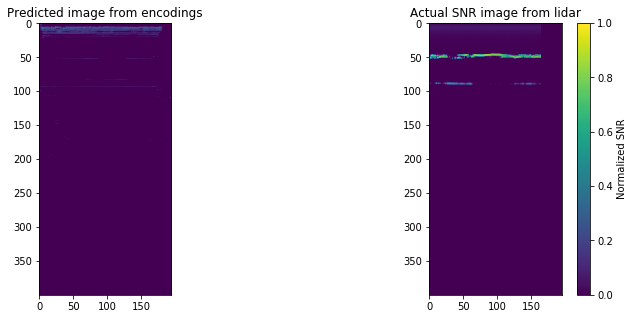

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow(predicted_set[10,:,:,0].T, vmin=0, vmax=1)
ax[0].set_title('Predicted image from encodings')
c = ax[1].imshow(observed_set[10,:,:,0].T, vmin=0, vmax=1)
ax[1].set_title('Actual SNR image from lidar')
plt.colorbar(c, ax=ax[1], label='Normalized SNR')

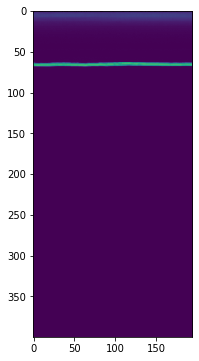

In [13]:
plt.figure(figsize=(10,6))
plt.imshow(observed_set[12,:,:,0].T, vmin=0, vmax=1)

In [53]:
predicted_set[12,:,:,0]

array([[0.18414336, 0.05784798, 0.05158192, ..., 0.04642639, 0.050753  ,
        0.12982398],
       [0.08962706, 0.0191319 , 0.01661184, ..., 0.01514262, 0.01693615,
        0.10374683],
       [0.08008274, 0.01580891, 0.01367441, ..., 0.01226014, 0.01369983,
        0.09470752],
       ...,
       [0.06935835, 0.0131906 , 0.01120579, ..., 0.00982255, 0.01086599,
        0.08800167],
       [0.06981632, 0.01332211, 0.0112935 , ..., 0.00989696, 0.01097006,
        0.08866358],
       [0.1263856 , 0.05585331, 0.05092207, ..., 0.04989919, 0.05286768,
        0.29370615]], dtype=float32)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584   

In [167]:
encoder_model = Model(inp, encoded)
encoder_model.load_weights('/home/rjackson/arming_the_edge/models/encoder-decoder/model-z-only-5min-100.hdf5',
                           by_name=True)   
encoder_model.compile(optimizer='adam', loss='mean_squared_error')
encoder_model.save('encoder_ref.hdf')

INFO:tensorflow:Assets written to: encoder_ref.hdf/assets


In [206]:
encoder_model.layers[0]

In [168]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584 

In [169]:
num_batches = 150
testset_batch = testset.take(150)
trainset_batch = trainset.take(150)
test_arrays = [x[0]["input_1"].numpy() for x in testset_batch]
train_arrays = [x[0]["input_1"].numpy() for x in trainset_batch]
test_times = np.stack([pd.to_datetime(x[0]["start_time"].numpy()) for x in testset_batch])
train_times = np.stack([pd.to_datetime(x[0]["start_time"].numpy()) for x in trainset_batch])

In [173]:
test_labels = np.array([get_label(dt64_to_dt(x)) for x in test_times.flatten()])
train_labels = np.array([get_label(dt64_to_dt(x)) for x in train_times.flatten()])

/home/rjackson/.conda/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [32]:
test_labels.shape

(3000,)

In [170]:
encoded_data_test = [encoder_model.predict(x) for x in test_arrays]
encoded_data_train = [encoder_model.predict(x) for x in train_arrays]
my_shp = encoded_data_train[0].shape

In [171]:
encoded_data_test = np.stack([x.reshape((my_shp[0], np.prod(my_shp[1:]))) for x in encoded_data_test])
encoded_data_train = np.stack([x.reshape((my_shp[0], np.prod(my_shp[1:]))) for x in encoded_data_train])
my_new_shape = encoded_data_test.shape
encoded_data_test = encoded_data_test.reshape((my_new_shape[0]*my_new_shape[1], my_new_shape[2]))
encoded_data_train = encoded_data_train.reshape((my_new_shape[0]*my_new_shape[1], my_new_shape[2]))

In [38]:
encoded_data_train.shape

(3000, 10000)

## Train GBM with with hyperparameter optimization

In [41]:
from hyperopt import hp, tpe, fmin, Trials, rand
my_space = {'max_depth': hp.randint('max_depth', 10),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'n_estimators': hp.uniform('n_estimators', 50, 200)}


N_FOLDS = 10
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    train_set = xgb.DMatrix(encoded_data_train, label=train_labels)
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = xgb.cv(params, train_set, nfold = n_folds, num_boost_round = 10000, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
   
    print(cv_results)
    # Extract the best score
    best_score = max(cv_results['test-auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [129]:
bayes_trials = Trials()

In [174]:
where_nan = np.isnan(train_labels)
encoded_data_train = encoded_data_train[~where_nan, :]
train_labels = train_labels[~where_nan]
where_nan_test = np.isnan(test_labels)
encoded_data_test = encoded_data_test[~where_nan_test, :]
test_labels = test_labels[~where_nan_test]

In [153]:
encoded_data_train.shape

(2816, 4624)

In [49]:
from sklearn.model_selection import GridSearchCV
my_classifier = XGBClassifier(n_jobs=8, max_depth=5)

#my_classifier.fit(encoded_data_train, train_labels, verbose=True)

In [175]:
my_classifier = XGBClassifier(n_jobs=8, learning_rate=0.01, max_depth=17, n_estimators=700)
my_classifier.fit(encoded_data_train, train_labels, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=17,
              min_child_weight=1, missing=None, n_estimators=700, n_jobs=8,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [176]:
labels_predict_test = my_classifier.predict(encoded_data_test)
labels_predict_train = my_classifier.predict(encoded_data_train)

In [177]:
num_correct = len(np.where(test_labels - labels_predict_test == 0)[0])
total = len(test_labels)
print("Percent correct in testing set: %3.2f" % (num_correct/total * 100))
num_correct = len(np.where(train_labels - labels_predict_train == 0)[0])
total = len(train_labels)
print("Percent correct in training set: %3.2f" % (num_correct/total * 100))

Percent correct in testing set: 88.73
Percent correct in training set: 100.00


In [203]:
num_correct = len(np.where(np.logical_and(test_labels == 0, labels_predict_test == 0))[0])
total = len(np.where(test_labels == 0)[0])
print("Percent correct in testing set when clear: %3.2f" % (num_correct/total * 100))
num_correct = len(np.where(np.logical_and(train_labels == 0, labels_predict_train == 0))[0])
total = len(np.where(train_labels == 0)[0])
print("Percent correct in training set when clear: %3.2f" % (num_correct/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 0, labels_predict_test == 1))[0])
print("Percent falsely identified as cloudy: %3.2f" % (num_incorrect/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 0, labels_predict_test == 2))[0])
print("Percent falsely indentifed as rain: %3.2f" % (num_incorrect/total * 100))

Percent correct in testing set when clear: 92.99
Percent correct in training set when clear: 100.00
Percent falsely identified as cloudy: 6.93
Percent falsely indentifed as rain: 0.12


In [201]:
num_correct = len(np.where(np.logical_and(test_labels == 1, labels_predict_test == 1))[0])
total = len(np.where(test_labels == 1)[0])
print("Percent correct in testing set when cloudy: %3.2f" % (num_correct/total * 100))
num_correct = len(np.where(np.logical_and(train_labels == 1, labels_predict_train == 1))[0])
total = len(np.where(train_labels == 1)[0])
print("Percent correct in training set when cloudy: %3.2f" % (num_correct/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 1, labels_predict_test == 0))[0])
print("Percent falsely identified as clear: %3.2f" % (num_incorrect/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 1, labels_predict_test == 2))[0])
print("Percent falsely indentifed as rain: %3.2f" % (num_incorrect/total * 100))

Percent correct in testing set when cloudy: 91.54
Percent correct in training set when cloudy: 100.00
Percent falsely identified as clear: 6.56
Percent falsely indentifed as rain: 1.90


In [204]:
num_correct = len(np.where(np.logical_and(test_labels == 2, labels_predict_test == 2))[0])
total = len(np.where(test_labels == 2)[0])
print("Percent correct in testing set when rainy: %3.2f" % (num_correct/total * 100))
num_correct = len(np.where(np.logical_and(train_labels == 2, labels_predict_train == 2))[0])
total = len(np.where(train_labels == 2)[0])
print("Percent correct in training set when rainy: %3.2f" % (num_correct/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 2, labels_predict_test == 0))[0])
print("Percent falsely identified as clear: %3.2f" % (num_incorrect/total * 100))
num_incorrect = len(np.where(np.logical_and(test_labels == 2, labels_predict_test == 1))[0])
print("Percent falsely identified as cloudy: %3.2f" % (num_incorrect/total * 100))

Percent correct in testing set when rainy: 26.88
Percent correct in training set when rainy: 100.00
Percent falsely identified as clear: 27.32
Percent falsely identified as cloudy: 36.61


In [158]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
#from xgboost.dask import DaskDMatrix
import xgboost as xgb

In [57]:
client = Client(cluster)

In [58]:
client

Client Scheduler: tcp://127.0.0.1:32983,Cluster Workers: 1 Cores: 1 Memory: 67.47 GB


## View hyperparameter optimization statistics

In [180]:
hyperparameter_csv = pd.read_csv('hyperparameter_opt.csv')

In [181]:
hyperparameter_csv

,Unnamed: 0,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_learning_rate,param_max_depth,param_n_estimators
0,0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",175.277152,3.834706,0.248725,0.006368,0.702875,0.660277,0.729211,0.697443,0.028401,646,0.01,3,50
1,1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",351.185097,6.910159,0.299968,0.043147,0.723110,0.685836,0.731343,0.713423,0.019800,644,0.01,3,100
2,2,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",514.511451,17.086525,0.272727,0.023360,0.729499,0.700745,0.739872,0.723366,0.016551,643,0.01,3,150
3,3,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",658.587984,56.850901,0.315595,0.044961,0.744409,0.712460,0.756930,0.737926,0.018723,640,0.01,3,200
4,4,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",886.797135,8.119693,0.313909,0.053668,0.755059,0.729499,0.764392,0.749645,0.014749,636,0.01,3,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,641,"{'learning_rate': 0.11, 'max_depth': 19, 'n_es...",2235.972820,28.902699,0.368198,0.077634,0.775293,0.745474,0.835821,0.785511,0.037582,278,0.11,19,750
642,642,"{'learning_rate': 0.11, 'max_depth': 19, 'n_es...",2117.436320,155.179386,0.243385,0.006220,0.773163,0.745474,0.835821,0.784801,0.037788,291,0.11,19,800
643,643,"{'learning_rate': 0.11, 'max_depth': 19, 'n_es...",1992.186106,451.065457,0.232251,0.121593,0.772098,0.745474,0.836887,0.784801,0.038382,291,0.11,19,850
644,644,"{'learning_rate': 0.11, 'max_depth': 19, 'n_es...",2117.707810,150.885272,0.184989,0.041544,0.772098,0.745474,0.836887,0.784801,0.038382,291,0.11,19,900


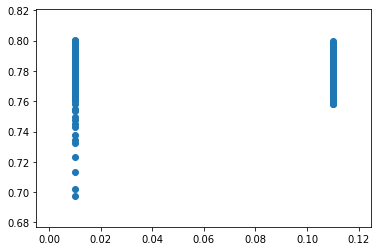

In [188]:
plt.scatter(hyperparameter_csv.param_learning_rate, hyperparameter_csv.mean_test_score)

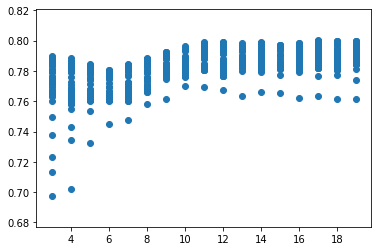

In [186]:
plt.scatter(hyperparameter_csv.param_max_depth, hyperparameter_csv.mean_test_score)

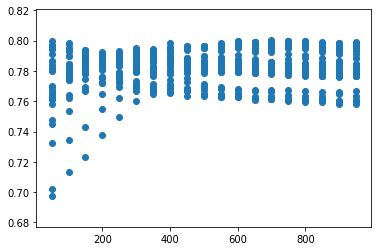

In [187]:
plt.scatter(hyperparameter_csv.param_n_estimators, hyperparameter_csv.mean_test_score)